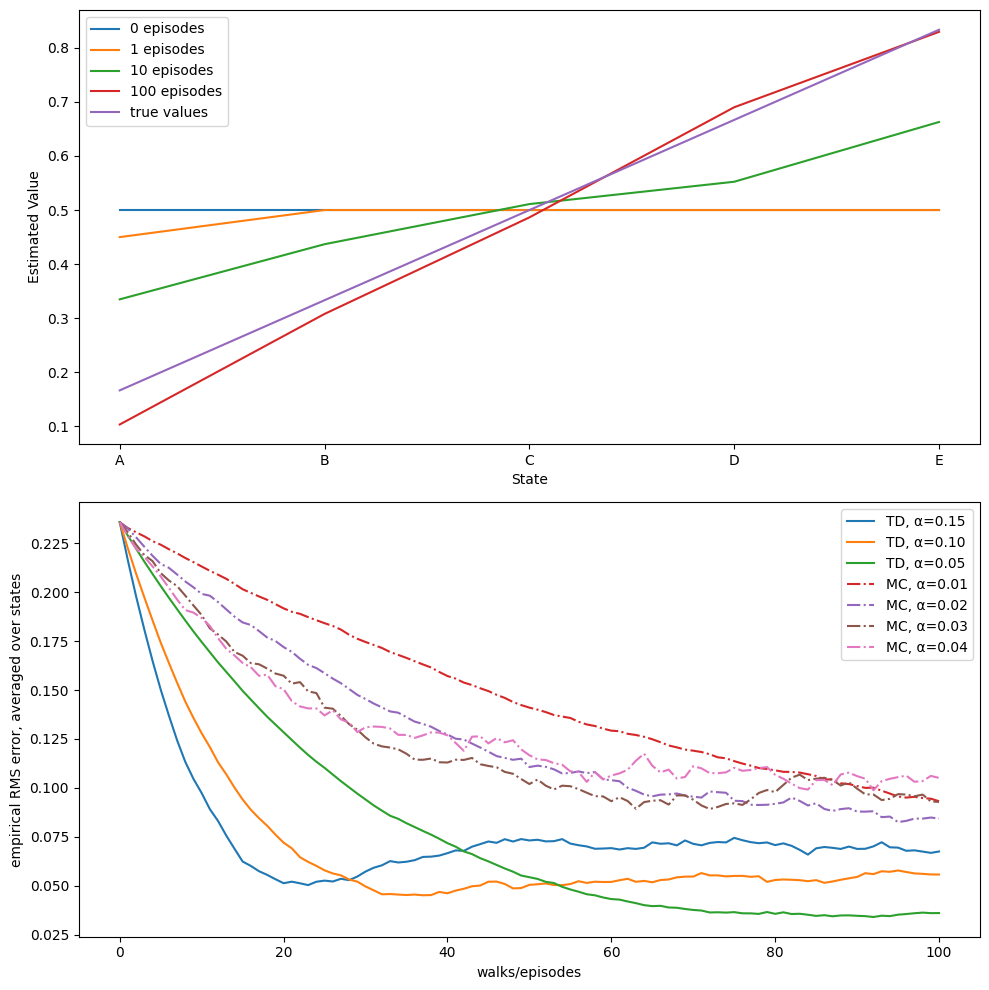

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class RandomWalk:
    def __init__(self):
        self.num_states = 7
        self.start_state = 3
        self.left_terminal = 0
        self.right_terminal = 6
        self.action_left = 0
        self.action_right = 1

        self.true_value = self._calculate_true_value()
        self.initial_values = self._get_initial_values()

    def _calculate_true_value(self):
        # calculate true values for states A-E
        true_val = np.zeros(self.num_states)
        true_val[1:6] = np.arange(1, 6) / 6.0
        true_val[self.right_terminal] = 1
        return true_val

    def _get_initial_values(self):
        # get starting estimates for the state values
        initial_val = np.zeros(self.num_states)
        initial_val[1:6] = 0.5
        initial_val[self.right_terminal] = 1
        return initial_val

class Experiment:
    def __init__(self, env, td_alphas, mc_alphas, episodes, runs):
        self.env = env
        self.td_alphas = td_alphas
        self.mc_alphas = mc_alphas
        self.episodes = episodes
        self.runs = runs

    def temporal_difference(self, values, alpha=0.1):
        # performs a single episode of the TD(0) algorithm.
        state = self.env.start_state
        while True:
            old_state = state
            if np.random.binomial(1, 0.5) == self.env.action_left:
                state -= 1
            else:
                state += 1
            # reward is 0 for all transitions, except to state 6 (which is handled by the value of state 6 being 1)
            reward = 0
            values[old_state] += alpha * (reward + values[state] - values[old_state])
            if state == self.env.right_terminal or state == self.env.left_terminal:
                break

    def monte_carlo(self, values, alpha=0.1):
        # performs a single episode of the every-visit monte carlo algorithm.
        state = self.env.start_state
        trajectory = [state]
        while True:
            if np.random.binomial(1, 0.5) == self.env.action_left:
                state -= 1
            else:
                state += 1
            trajectory.append(state)
            if state == self.env.right_terminal:
                returns = 1.0
                break
            elif state == self.env.left_terminal:
                returns = 0.0
                break
        for s in trajectory[:-1]: # update all states visited *before* the terminal one
            values[s] += alpha * (returns - values[s])

    def plot_state_values(self, ax):
        # plots the estimated state values after 0, 1, 10, and 100 episodes.
        episodes_to_plot = [0, 1, 10, 100]
        current_values = np.copy(self.env.initial_values)

        for i in range(episodes_to_plot[-1] + 1):
            if i in episodes_to_plot:
                ax.plot(("A", "B", "C", "D", "E"),
                        current_values[1:6],
                        label=f'{i} episodes')
            self.temporal_difference(current_values, alpha=0.1)

        ax.plot(("A", "B", "C", "D", "E"), self.env.true_value[1:6], label='true values')
        ax.set_xlabel('State')
        ax.set_ylabel('Estimated Value')
        ax.legend()

    def plot_rms_error(self, ax):
        # plots the empirical RMS error over episodes for various algorithms and alphas.
        all_alphas = self.td_alphas + self.mc_alphas
        for i, alpha in enumerate(all_alphas):
            total_errors = np.zeros(self.episodes)
            if i < len(self.td_alphas):
                method = 'TD'
                linestyle = 'solid'
                algo = self.temporal_difference
            else:
                method = 'MC'
                linestyle = 'dashdot'
                algo = self.monte_carlo
            for _ in tqdm(range(self.runs), leave=False):
                errors = []
                current_values = np.copy(self.env.initial_values)
                for ep in range(self.episodes):
                    rms = np.sqrt(np.sum(np.power(self.env.true_value - current_values, 2)) / 5.0)
                    errors.append(rms)
                    algo(current_values, alpha=alpha)
                total_errors += np.asarray(errors)
            total_errors /= self.runs
            ax.plot(total_errors, linestyle=linestyle, label=f'{method}, α={alpha:.02f}')
        ax.set_xlabel('walks/episodes')
        ax.set_ylabel('empirical RMS error, averaged over states')
        ax.legend()

    def run_figure_6_1(self):
        fig, axes = plt.subplots(2, 1, figsize=(10, 10))
        self.plot_state_values(axes[0])
        self.plot_rms_error(axes[1])
        plt.tight_layout()
        plt.show()

rw_env = RandomWalk()

# experiment param
td_alphas = [0.15, 0.1, 0.05]
mc_alphas = [0.01, 0.02, 0.03, 0.04]
episodes_for_rms = 101                  # run for 101 episodes (0 to 100)
num_runs = 100                          # average over 100 runs

# create and run the experiment
experiment = Experiment(
    env=rw_env,
    td_alphas=td_alphas,
    mc_alphas=mc_alphas,
    episodes=episodes_for_rms,
    runs=num_runs
)

experiment.run_figure_6_1()